In [2]:
from typing import Dict, Any
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import chromadb
import numpy as np
import torch
import joblib
import dotenv
dotenv.load_dotenv()

True

In [3]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

mps


In [4]:
from inflection.datasets import PairEmbeddingDataset, parse_db_result

In [5]:
CHROMA_PATH = '../chroma/'
client = chromadb.PersistentClient(path = CHROMA_PATH, settings = chromadb.Settings(anonymized_telemetry=False))

In [6]:
expression_collection = client.get_collection("expression_collection")
solution_collection = client.get_collection("solution_collection")

In [7]:
evaluation_collection = client.get_collection("evaulation_collection")

In [8]:
result = expression_collection.get(include=['embeddings', 'metadatas', 'documents'])
expression_df = parse_db_result(result)

result = solution_collection.get(include=['embeddings', 'metadatas', 'documents'])
solution_df = parse_db_result(result)

# Join the two dataframes on product_int # TODO: Update solution database to include num1 and num2
df = pd.merge(expression_df, solution_df, on=['number_1_int', 'number_2_int'], how='inner')

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
batch_size = 32 
learning_rate = 0.0005

In [11]:
train_dataset = PairEmbeddingDataset(train_df, device=device)
test_dataset = PairEmbeddingDataset(test_df, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y, y_int = next(iter(test_dataloader))
EMBEDDING_SIZE = X.shape[1]

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingPredictor(nn.Module):
    def __init__(self, embedding_size: int) -> None:
        super(EmbeddingPredictor, self).__init__()
        self.embedding_size = embedding_size
        self.fc1 = nn.Linear(embedding_size, embedding_size * 2)
        self.fc2 = nn.Linear(embedding_size * 2, embedding_size * 2)
        self.fc3 = nn.Linear(embedding_size * 2, embedding_size * 2)
        self.fc4 = nn.Linear(embedding_size * 2, embedding_size * 2)
        self.fc5 = nn.Linear(embedding_size * 2, embedding_size * 2)
        self.fc6 = nn.Linear(embedding_size * 2, embedding_size)
        self.leaky_relu = nn.LeakyReLU()
  
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        x = F.normalize(self.fc6(x), p=2, dim=1)
        return x

In [13]:
def similarity_loss(y_true, y_pred):
    return 1 - F.cosine_similarity(y_true, y_pred).mean()

In [14]:
model = EmbeddingPredictor(embedding_size=EMBEDDING_SIZE)
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.75, threshold=1e-4, verbose=True)

criterion = similarity_loss 

In [15]:
losses = []
val_losses = []
best_val_loss = np.inf

In [84]:
epochs = 300 

In [85]:
for epoch in range(epochs):
    model.train()

    batch_losses = 0
    for X_batch, y_batch, _ in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch)
        batch_losses += loss.item()

        loss.backward()
        optimizer.step()
    
    batch_losses /= len(train_dataloader)
    losses.append(batch_losses)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_batch_losses = 0
        for X_batch, y_batch, _ in val_dataloader:
            y_pred = model(X_batch)
            val_loss = criterion(y_pred, y_batch)
            val_batch_losses += val_loss.item()

    val_batch_losses /= len(val_dataloader)
    val_losses.append(val_batch_losses)

    if val_batch_losses < best_val_loss:
        best_val_loss = val_batch_losses
        torch.save(model.state_dict(), f'../training_checkpoints/best_model_ada.pt')
    
    scheduler.step(val_batch_losses)

    print(f'Epoch {epoch+1}/{epochs}: train_loss={batch_losses}, val_loss={val_batch_losses}')

Epoch 1/300: train_loss=0.04151909518241882, val_loss=0.031971968355632964
Epoch 2/300: train_loss=0.03199829936027527, val_loss=0.032311913513001944
Epoch 3/300: train_loss=0.03169762134552002, val_loss=0.032127083293975345
Epoch 4/300: train_loss=0.03147549295425415, val_loss=0.03153634165960645
Epoch 5/300: train_loss=0.0312361843585968, val_loss=0.03113298662125118
Epoch 6/300: train_loss=0.03129607748985291, val_loss=0.03127981083733695
Epoch 7/300: train_loss=0.03111472487449646, val_loss=0.031128970403519887
Epoch 8/300: train_loss=0.031125964164733885, val_loss=0.031150390231420123
Epoch 9/300: train_loss=0.03109047508239746, val_loss=0.030981249279446073
Epoch 10/300: train_loss=0.030973402976989747, val_loss=0.0311281681060791
Epoch 11/300: train_loss=0.03097220253944397, val_loss=0.030984191667465938
Epoch 12/300: train_loss=0.030859912395477297, val_loss=0.030907003652481807
Epoch 13/300: train_loss=0.030245627880096434, val_loss=0.029402098012348964
Epoch 14/300: train_los

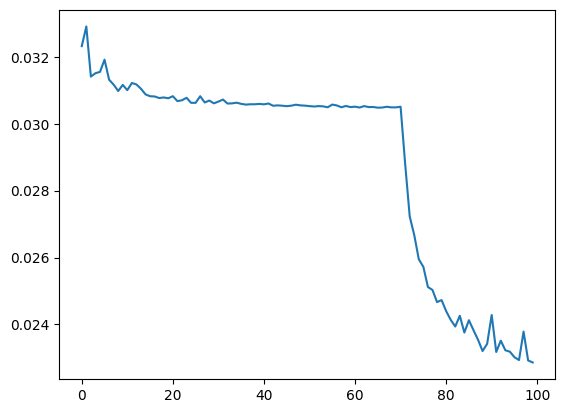

In [71]:
plt.plot(val_losses)

In [16]:
# Load the best model
model = EmbeddingPredictor(embedding_size=EMBEDDING_SIZE)
model.load_state_dict(torch.load('../training_checkpoints/best_model_ada_v0p0.pt'))
model.to(device)

EmbeddingPredictor(
  (fc1): Linear(in_features=1536, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=3072, bias=True)
  (fc3): Linear(in_features=3072, out_features=3072, bias=True)
  (fc4): Linear(in_features=3072, out_features=3072, bias=True)
  (fc5): Linear(in_features=3072, out_features=3072, bias=True)
  (fc6): Linear(in_features=3072, out_features=1536, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
)

In [ ]:
model.eval()
predicted_embeddings = []
actual_embeddings = []
i = 1
for X_batch, y_batch, y_batch_int in test_dataloader:
    with torch.no_grad():
        y_pred = model(X_batch)
        y_pred = y_pred.cpu().numpy().reshape(-1)
        predicted_embeddings.append(y_pred)
        actual_number = y_batch_int[0].item()
        print(f'Actual number: {y_batch_int[0]}')
        result = solution_collection.query(query_embeddings=y_pred.tolist(), n_results=1, include=['metadatas', 'embeddings'])
        result_number = result['metadatas'][0][0]['product_int']
        result_embedding = result['embeddings'][0][0]
        actual_embeddings.append(np.array(result_embedding))
        print(f'Predicted number: {result_number}')
        print('-------------------')
        #diffs.append(abs(actual_number - result_number) - 10_000_000)
    i+=1
#print(f'Average difference: {np.mean(diffs)}')
joblib.dump({'predicted_embeddings': predicted_embeddings, 'actual_embeddings': actual_embeddings}, '../training_checkpoints/embeddings.joblib')

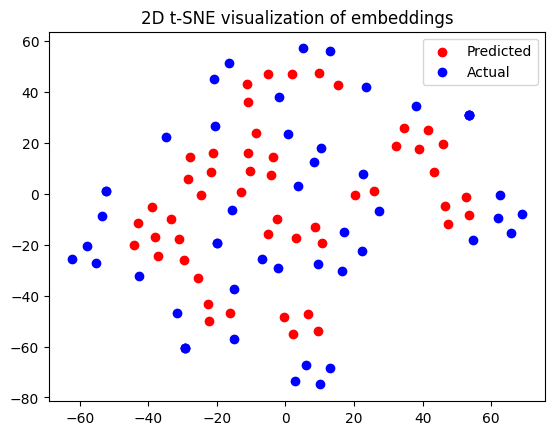

In [27]:
from sklearn.manifold import TSNE
predicted_embeddings = np.array(predicted_embeddings)
actual_embeddings = np.array(actual_embeddings)
# Combine the data for t-SNE processing
data = np.vstack((predicted_embeddings, actual_embeddings))

# Apply t-SNE transformation to 2D
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(data)

# Split the reduced data for plotting
list1_2d = reduced_data[:50, :]
list2_2d = reduced_data[50:, :]

# Plot
plt.scatter(list1_2d[:, 0], list1_2d[:, 1], color='red', label='Predicted')
plt.scatter(list2_2d[:, 0], list2_2d[:, 1], color='blue', label='Actual')
plt.legend()
plt.title('2D t-SNE visualization of embeddings')
plt.show()
#predicted_embeddings
# Actual embeddings

